In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import scipy.sparse as sp

In [2]:
file_path = "dataset_phishing_2023-08-16.csv"
df = pd.read_csv(file_path, sep='\t')

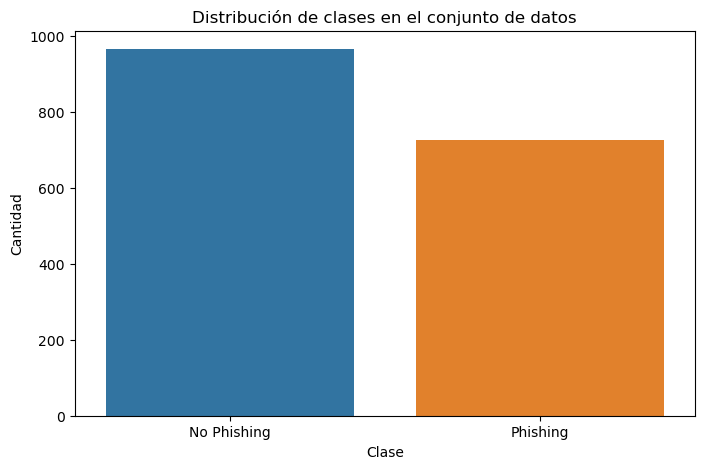

In [3]:
# Crear una columna categórica para representar las etiquetas
df['class'] = df['phishing'].map({0: 'No Phishing', 1: 'Phishing'})

# Gráfico de barras usando seaborn
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='class')
plt.title('Distribución de clases en el conjunto de datos')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()


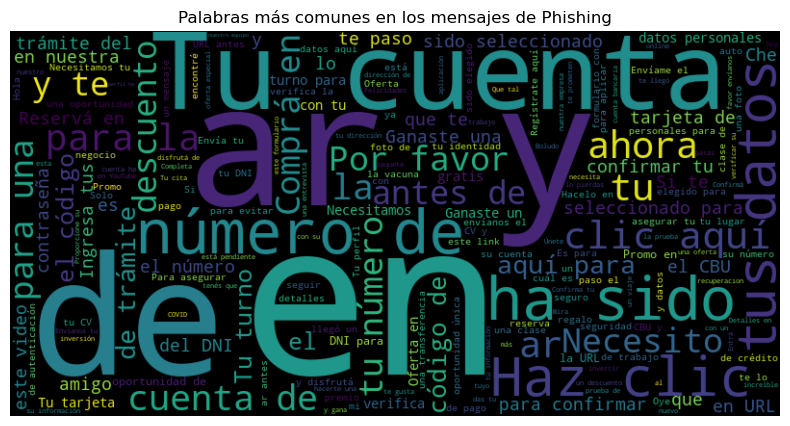

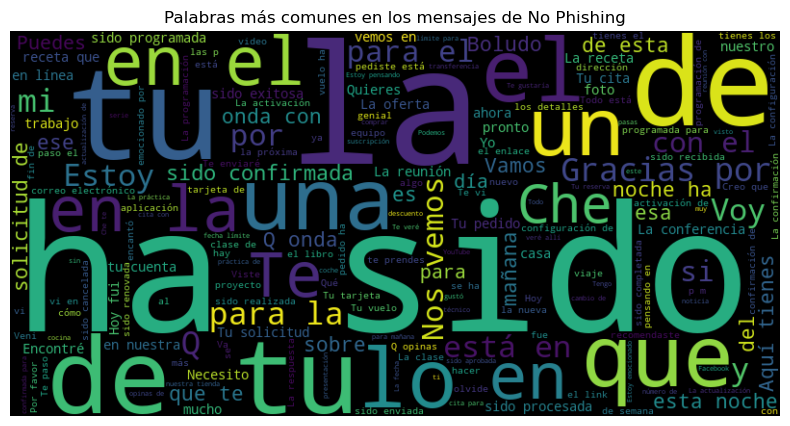

In [4]:
# Separar los mensajes por clase
phishing_text = ' '.join(df[df['phishing'] == 1]['message'])
non_phishing_text = ' '.join(df[df['phishing'] == 0]['message'])

# Crear y mostrar la nube de palabras para la clase Phishing
phishing_wordcloud = WordCloud(width=800, height=400).generate(phishing_text)
plt.figure(figsize=(10,5))
plt.imshow(phishing_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más comunes en los mensajes de Phishing')
plt.show()

# Crear y mostrar la nube de palabras para la clase No Phishing
non_phishing_wordcloud = WordCloud(width=800, height=400).generate(non_phishing_text)
plt.figure(figsize=(10,5))
plt.imshow(non_phishing_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más comunes en los mensajes de No Phishing')
plt.show()


In [5]:
def preprocess_text(text):
    # Reemplazar números de CBU con un token específico
    text = re.sub(r'\b\d{20}\b', 'CBUTOKEN', text)
    # Reemplazar números de cuenta con un token específico
    text = re.sub(r'\b\d{4}/\d{8}/\d{2}\b|\b\d{14}\b', 'ACCOUNTNUMBERTOKEN', text)
    # Reemplazar números de teléfono de WhatsApp (Argentina) con un token específico
    text = re.sub(r'\+\d{13}|\b\d{10}\b', 'WHATSAPPTOKEN', text)
    # Reemplazar montos con un token específico
    text = re.sub(r'\$\d+', 'MONTOTOKEN', text)
    # Reemplazar URLs por un token específico
    text = re.sub(r'http\S+|www\S+', 'URLTOKEN', text)
    # Eliminar acentos
    text = unidecode(text)
    # Convertir a minúscula y eliminar signos de puntuación
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Eliminar números
#     text = re.sub(r'\d+', '', text)
#     Eliminar palabras vacías y aplicar stemming
#     text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    return text

In [6]:
# messages = df['message']
# is_phishing = df['phishing']

X_train, X_test, y_train, y_test = train_test_split(df[['message', 'tiene_https', 'longitud_url', 'presencia_subdominio', 'palabras_clave_sospechosas']], df['phishing'], test_size=0.33, random_state=42)

X_train['message'] = X_train['message'].apply(preprocess_text)
X_test['message'] = X_test['message'].apply(preprocess_text)

df['message'] = df['message'].apply(preprocess_text)

# Ver las primeras 10 filas del dataset
# df.head(15)
# df[df['message'].str.contains('token', case=False, na=False)].head(5)

In [7]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['message'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['message'])

# Escalando las características numéricas, incluyendo 'palabras_clave_sospechosas'
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train[['tiene_https', 'longitud_url', 'presencia_subdominio', 'palabras_clave_sospechosas']])
X_test_features = scaler.transform(X_test[['tiene_https', 'longitud_url', 'presencia_subdominio', 'palabras_clave_sospechosas']])

# Combinando las características de TF-IDF con las características adicionales
X_train_combined = sp.hstack((X_train_tfidf, X_train_features))
X_test_combined = sp.hstack((X_test_tfidf, X_test_features))

In [8]:
logreg = LogisticRegression()
logreg.fit(X_train_combined, y_train)

LogisticRegression()

In [9]:
y_pred = logreg.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_rep)

Accuracy: 92.84%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       317
           1       0.93      0.90      0.92       242

    accuracy                           0.93       559
   macro avg       0.93      0.93      0.93       559
weighted avg       0.93      0.93      0.93       559



In [10]:
stop_words = set(stopwords.words('spanish'))
ps = PorterStemmer()

def preprocess_text_before_test(text):
    # Reemplazar números de CBU con un token específico
    text = re.sub(r'\b\d{20}\b', 'CBUTOKEN', text)
    # Reemplazar números de cuenta con un token específico
    text = re.sub(r'\b\d{4}/\d{8}/\d{2}\b|\b\d{14}\b', 'ACCOUNTNUMBERTOKEN', text)
    # Reemplazar números de teléfono de WhatsApp (Argentina) con un token específico
    text = re.sub(r'\+\d{13}|\b\d{10}\b', 'WHATSAPPTOKEN', text)
    # Reemplazar montos con un token específico
    text = re.sub(r'\$\d+|\d+\$', 'MONTOTOKEN', text)
    # Reemplazar URLs por un token específico
    text = re.sub(r'http\S+|www\S+', 'URLTOKEN', text)
    # Eliminar acentos
    text = unidecode(text)
    # Convertir a minúscula y eliminar signos de puntuación
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Eliminar números
#     text = re.sub(r'\d+', '', text)
#     Eliminar palabras vacías y aplicar stemming
    text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    return text

In [19]:
# Supongamos que este es el nuevo mensaje y sus características asociadas
# new_message = preprocess_text_before_test("Necesito realizar una transferencia y no me deja el homebanking. La podras hacer vos y yo te lo reintegro? Necesito $15000. 4530000312351243 es el CBU, y el numero de cuenta es 35312411")
# new_message = preprocess_text_before_test("A mi me solucionaron el inconveniente a traves del WhatsApp 114058343423")
# new_message = preprocess_text_before_test("Soy del soporte tecnico de facebook, alguien ingreso a tu cuenta cambia tu clave desde www.sitiodephishing.com")
print(new_message)
new_features = {'tiene_https': 0, 'longitud_url': 0, 'presencia_subdominio': 0, 'palabras_clave_sospechosas': 0}

# Transformar el mensaje con TF-IDF (utilizando el mismo tfidf_vectorizer que entrenaste antes)
new_message_tfidf = tfidf_vectorizer.transform([new_message])

# Escalar y combinar las características numéricas
new_features_scaled = scaler.transform([list(new_features.values())])
new_combined_features = sp.hstack((new_message_tfidf, new_features_scaled))

# Utilizar el modelo para predecir
new_prediction = logreg.predict(new_combined_features)

# Interpretar la predicción
if new_prediction[0] == 1:
    print("El mensaje es phishing")
else:
    print("El mensaje no es phishing")


necesito realizar transferencia deja homebank podra hacer vo reintegro necesito montotoken 4530000312351243 cbu numero cuenta 35312411
El mensaje no es phishing


C:\tools\Anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [20]:
# Supongamos que este es el nuevo mensaje
# new_message = preprocess_text_before_test("Hola, A mi me solucionaron el inconviente mas rapido a traves del WhatsApp 1140793709")
new_message = preprocess_text_before_test("A mi me solucionaron el inconveniente a traves del WhatsApp 114058343423")
print(new_message)
# Transformar el mensaje con TF-IDF
new_message_tfidf = tfidf_vectorizer.transform([new_message])

# Como el modelo está entrenado con características adicionales, necesitas crear un vector de ceros para esas características
# Asume que hay 4 características adicionales como en el ejemplo anterior
additional_features_empty = sp.csr_matrix([[0, 0, 0, 0]])

# Combinar las características de TF-IDF con las características adicionales vacías
new_combined_features = sp.hstack((new_message_tfidf, additional_features_empty))

# Utilizar el modelo para predecir
new_prediction = logreg.predict(new_combined_features)

# Interpretar la predicción
if new_prediction[0] == 1:
    print("El mensaje es phishing")
else:
    print("El mensaje no es phishing")


solucionaron inconvenient trave whatsapp 114058343423
El mensaje es phishing


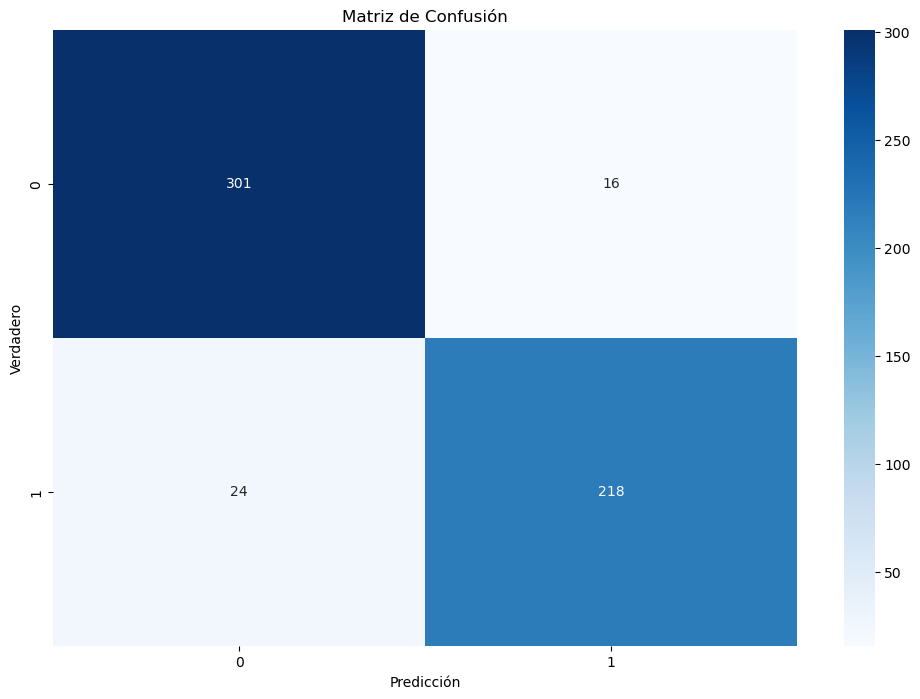

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

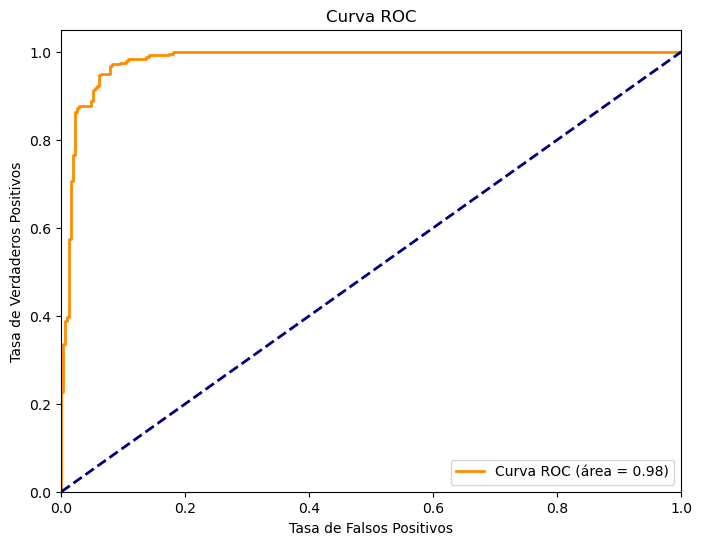

In [22]:
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, logreg.decision_function(X_test_combined))
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


### Para guardar el modelo 

Correr el proximo bloque

In [23]:
import joblib

# Guardar el modelo
joblib.dump(logreg, 'CHAT_MODEL.pkl')

# Guardar el vectorizador TF-IDF
joblib.dump(tfidf_vectorizer, 'VECTORIZER_CHAT_MODEL.pkl')

['VECTORIZER_CHAT_MODEL.pkl']